In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

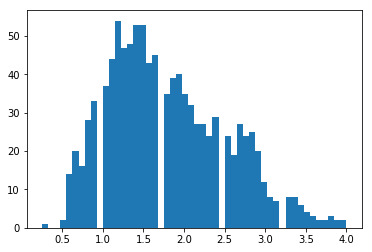

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


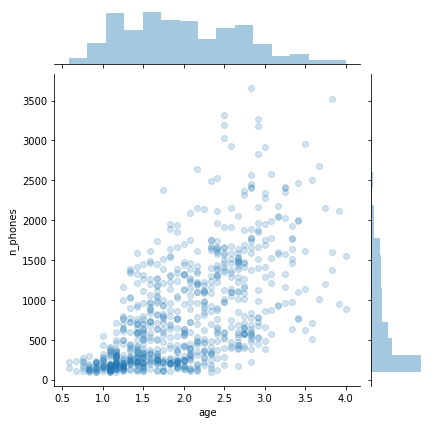

In [10]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [11]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [12]:
from childes_mi.information_theory import mutual_information as mi

#### Run MI by age cohort

In [29]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [30]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
    ]
)
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]

    cohort_phones = [[row.transcript_id + "_" + i for i in list(flatten(row.phones)) if i not in [None, 'xxx']] for idx, row in cohort_subset.iterrows()]
    
    n_phones = len(np.concatenate(cohort_phones))
    n_unique_phones = len(np.unique(np.concatenate(cohort_phones)))

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones, distances=distances, n_jobs=-1
    )

    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
    ]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    5.2s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    6.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    6.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    6.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   28.1s remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   39.7s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   34.4s remaining:   24.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   34.4s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   40.2s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   58.5s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   52.8s remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   52.8s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   46.9s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:  1.2min remaining:   18.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   59.7s remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   59.7s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   49.4s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:  1.2min remaining:   19.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:  1.1min remaining:   47.5s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:  1.1min remaining:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   27.7s remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   40.8s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:   39.5s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   39.5s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.1s finished


In [24]:
#mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi.pickle")

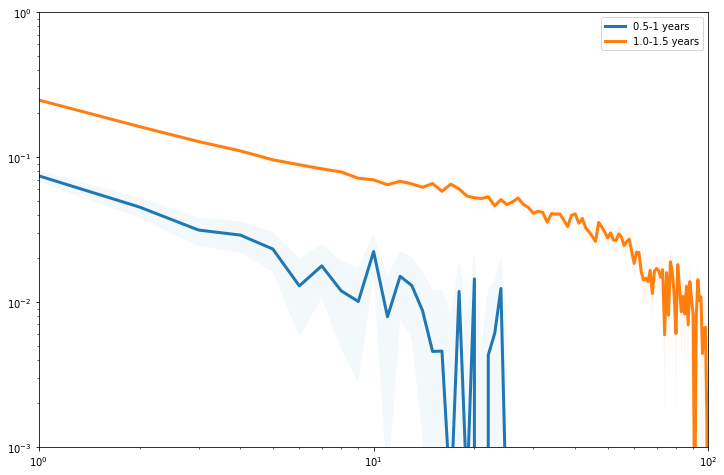

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

for idx, row in mi_df.iterrows():
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    #ax.scatter(distances, row.MI-row.shuff_MI)
    ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
    ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.05)
ax.legend()
ax.set_ylim([1e-3,1])
ax.set_xlim([1, 100])

ax.set_yscale('log')
ax.set_xscale('log')


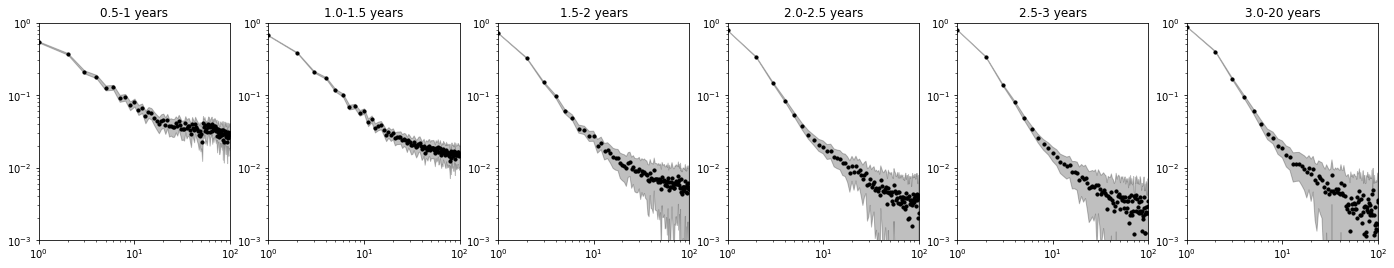

In [20]:
fig, axs = plt.subplots(ncols=len(mi_df), figsize=(4*len(mi_df),4))

for axi, (idx, row) in enumerate(mi_df.iterrows()):
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    #ax.scatter(distances, row.MI-row.shuff_MI)
    ax = axs[axi]
    #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
    ax.scatter(distances, row.MI-row.shuff_MI, s=10, color='k')
    ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
    #ax.legend()
    ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
    ax.set_ylim([1e-3,1])
    ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
